## Project 1


### Import Dependencies

In [266]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
import datetime
import math
import random
import hvplot.pandas
import panel as pn
from yahoo_fin import stock_info as si
from yahoo_earnings_calendar import YahooEarningsCalendar
from MCForecastTools import MCSimulation

In [267]:
# Load .env enviroment variables
initial_investment = 10000

from dotenv import load_dotenv
load_dotenv()

True

In [292]:
### Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


In [269]:
#Ask User for intitial investment
investment_slider = pn.widgets.FloatSlider(name='Initial Investment', start=1000, end=100000, step=100, value=10000)

investment_slider

FloatSlider(end=100000, name='Initial Investment', start=1000, step=100, value=10000, value_throttled=10000)

### Dynamically Pull Stocks Based on Earnings Date

In [270]:
#Store initial investment
initial_investment = investment_slider.value

58800

In [ ]:
#Ask the user for number of days to look at future earnings
day_slider = pn.widgets.FloatSlider(name='Please select the number of days to look at for earnings', start=1, end=25, step=1, value=2)

day_slider

In [293]:
#Store Selected days
furture_days = day_slider.value

FloatSlider(end=25, name='Please select t..., start=1, step=1, value=2, value_throttled=2)

In [272]:
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days = 1) 
start_time = tomorrow.strftime("%b %d %Y") + " 10:00AM"
next_day = today + datetime.timedelta(days = 2) 
end_time = next_day.strftime("%b %d %Y") + " 1:00PM"

date_from = datetime.datetime.strptime(
    start_time, '%b %d %Y %I:%M%p')
date_to = datetime.datetime.strptime(
    end_time, '%b %d %Y %I:%M%p')
yec = YahooEarningsCalendar()
stock_earnings = yec.earnings_between(date_from, date_to)


In [274]:
stock_list = [{'ticker': ticker['ticker'], 'epsestimate': ticker['epsestimate']} for ticker in stock_earnings if ticker['epsestimate']]
tickers = []
for i in stock_list:
    if i["ticker"] not in tickers:
        tickers.append((i["ticker"]))
        
print(tickers)

['VNCE', 'MCC', 'QD']


In [275]:
# Set timeframe to '1D'
timeframe = "1D"

#Set timeframe for last 2 years
start_date = pd.Timestamp("2018-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp(next_day, tz="America/New_York").isoformat()

#Get ticker data
df_ticker = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.head()

MCC                                 QD         \
                           open  high    low close    volume  open   high   
time                                                                        
2018-05-01 00:00:00-04:00  4.35  4.37  4.320  4.34   43625.0  9.86  10.09   
2018-05-02 00:00:00-04:00  4.33  4.35  4.270  4.28  103873.0  9.92  10.00   
2018-05-03 00:00:00-04:00  4.26  4.28  4.222  4.27  210100.0  9.80   9.86   
2018-05-04 00:00:00-04:00  4.25  4.28  4.240  4.25  109677.0  9.55  10.09   
2018-05-07 00:00:00-04:00  4.23  4.28  4.230  4.27  117048.0  9.99  10.49   

                                                   VNCE                    \
                            low   close   volume   open  high   low close   
time                                                                        
2018-05-01 00:00:00-04:00  9.86   9.880   533289  8.980  9.16  8.78  9.00   
2018-05-02 00:00:00-04:00  9.80   9.800   590760  8.990  9.00  8.89  9.00   
2018-05-03 00:00:00-04:00  9.56   9.700  1039428  9.000  9.00  8.82  9.00   
2018-05-04 00:00:00-04:00  9.55  10.075   929297  8.950  9.00  8.73  8.97   
2018-05-07 00:00:00-04:00  9.93  10.490   975196  8.916  9.07  8.86  9.00   

                                    
                            volume  
time                                
2018-05-01 00:00:00-04:00   8380.0  
2018-05-02 00:00:00-04:00   3590.0  
2018-05-03 00:00:00-04:00   6145.0  
2018-05-04 00:00:00-04:00  16647.0  
2018-05-07 00:00:00-04:00   9704.0

In [276]:
#Cleanup Pandas Data for Close Prices only
df_closing_prices = pd.DataFrame()

for ticker in tickers: 
    df_closing_prices[ticker] = df_ticker[ticker]["close"]

In [277]:
#Generate Closing Price Graph
df_closing_prices.index = df_closing_prices.index.date

daily_close = df_closing_prices.hvplot.line()
daily_close

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [278]:
#Generate Daily Returns Graph 
df_daily_returns = df_closing_prices.pct_change().dropna()

daily_returns = df_daily_returns.hvplot.line()
daily_returns

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [279]:
### Dynamically Generate Weights 

In [281]:
total = 1
weight_list = []
#portfolios = 5
#for num in range(len(portfolios)):
for i in range(len(tickers)):
    if i == (len(tickers)-1):
        weight_list.append(round(total,2))
    elif len(tickers) > 1 and len(tickers) <= 5:
        weight = (round(random.uniform(0,total),2))
        weight_list.append(round(weight,2))
        total -= weight
    elif len(tickers) > 5:
        weight = (round(random.uniform(0.1,total)/3,8))
        weight_list.append(round(weight,2))
        total -= weight        
    else:
        weight_list.append(1.0)
print(weight_list)

[0.31, 0.04, 0.65]


### The MCForecastTools Library at a Glance

### Simulate five year portfolio growth using Monte Carlo simulation

In [282]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_ticker,
    weights = weight_list,
    num_simulation = 500,
    num_trading_days = 252*5
)

In [283]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

MCC                                            \
                           open  high    low close    volume daily_return   
time                                                                        
2018-05-01 00:00:00-04:00  4.35  4.37  4.320  4.34   43625.0          NaN   
2018-05-02 00:00:00-04:00  4.33  4.35  4.270  4.28  103873.0    -0.013825   
2018-05-03 00:00:00-04:00  4.26  4.28  4.222  4.27  210100.0    -0.002336   
2018-05-04 00:00:00-04:00  4.25  4.28  4.240  4.25  109677.0    -0.004684   
2018-05-07 00:00:00-04:00  4.23  4.28  4.230  4.27  117048.0     0.004706   

                             QD                                             \
                           open   high   low   close   volume daily_return   
time                                                                         
2018-05-01 00:00:00-04:00  9.86  10.09  9.86   9.880   533289          NaN   
2018-05-02 00:00:00-04:00  9.92  10.00  9.80   9.800   590760    -0.008097   
2018-05-03 00:00:00-04:00  9.80   9.86  9.56   9.700  1039428    -0.010204   
2018-05-04 00:00:00-04:00  9.55  10.09  9.55  10.075   929297     0.038660   
2018-05-07 00:00:00-04:00  9.99  10.49  9.93  10.490   975196     0.041191   

                            VNCE                                          
                            open  high   low close   volume daily_return  
time                                                                      
2018-05-01 00:00:00-04:00  8.980  9.16  8.78  9.00   8380.0          NaN  
2018-05-02 00:00:00-04:00  8.990  9.00  8.89  9.00   3590.0     0.000000  
2018-05-03 00:00:00-04:00  9.000  9.00  8.82  9.00   6145.0     0.000000  
2018-05-04 00:00:00-04:00  8.950  9.00  8.73  8.97  16647.0    -0.003333  
2018-05-07 00:00:00-04:00  8.916  9.07  8.86  9.00   9704.0     0.003344

In [284]:
# Running a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00
1,8.920782e-01,0.903524,1.045075e+00,0.865117,1.369552,1.152085e+00,0.896487,1.269788e+00,0.828119,1.260157,...,1.131909e+00,9.289254e-01,0.898211,1.000282,1.128283e+00,1.061146,0.800343,0.953641,0.777005,6.893750e-01
2,8.800601e-01,1.045843,1.130747e+00,1.121217,1.421412,1.025187e+00,0.864882,1.362505e+00,1.055050,1.330005,...,9.330157e-01,1.241435e+00,0.599248,1.123589,1.366185e+00,0.925647,0.858658,0.844848,0.998648,7.950066e-01
3,7.282425e-01,1.044432,1.487986e+00,1.307160,1.384253,1.083761e+00,0.672333,1.088921e+00,1.130491,0.991171,...,8.919052e-01,9.954092e-01,0.490474,0.839123,1.498678e+00,0.834924,0.879379,0.760222,1.370471,9.347403e-01
4,6.207378e-01,1.033991,1.642112e+00,1.801137,1.367916,1.247356e+00,0.519766,1.135194e+00,1.306276,0.770483,...,8.447486e-01,8.005430e-01,0.599410,0.755308,1.807578e+00,0.895152,0.665361,0.644042,1.461280,8.292352e-01
5,4.780219e-01,1.263929,1.558914e+00,2.102020,1.546566,8.076617e-01,0.526684,9.669208e-01,0.928581,0.826355,...,9.160000e-01,9.707400e-01,0.488579,0.859964,1.903549e+00,0.821586,0.809981,0.569677,1.391065,1.102276e+00
6,3.777040e-01,1.256620,2.221205e+00,1.959838,1.343902,7.655369e-01,0.608135,9.665630e-01,0.690571,0.927617,...,8.446488e-01,9.365397e-01,0.555581,0.982517,1.858514e+00,1.063870,0.770822,0.490661,1.488223,8.431406e-01
7,5.352783e-01,1.194110,1.471418e+00,2.040376,1.999983,6.936020e-01,0.769534,1.145962e+00,0.663517,0.726068,...,7.754479e-01,8.177404e-01,0.541827,0.995117,2.014404e+00,1.104687,0.696088,0.550250,1.188373,9.842216e-01
8,6.111144e-01,1.582633,1.734182e+00,1.797132,2.137241,6.846120e-01,0.793991,1.421647e+00,0.724864,0.744690,...,6.827357e-01,6.321193e-01,0.555050,0.949925,2.158350e+00,0.742110,0.600375,0.484979,1.332227,4.915834e-01
9,4.796082e-01,1.315920,1.790665e+00,1.919727,2.169264,7.829043e-01,0.595780,1.526004e+00,0.817670,0.941970,...,5.238050e-01,4.556373e-01,0.577641,1.135396,2.126823e+00,0.421830,0.666055,0.453457,1.334914,5.474046e-01


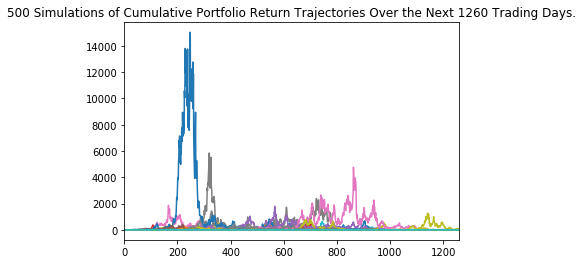

In [285]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

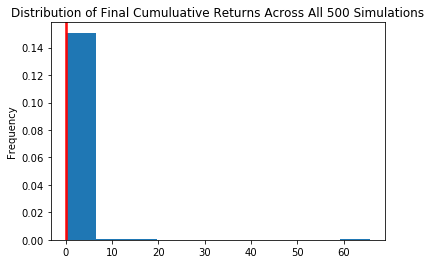

In [286]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [287]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           5.000000e+02
mean            2.193816e-01
std             3.083335e+00
min             2.551369e-16
25%             1.293305e-09
50%             9.402948e-08
75%             1.233225e-05
max             6.574540e+01
95% CI Lower    9.762555e-14
95% CI Upper    3.094799e-01
Name: 1260, dtype: float64


In [291]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $58800 in the portfolio over the next 5 years will end within in the range of $0.0 and $18197.42


In [290]:
portfolio = {}
for ticker in tickers:
    stock_weight = weight_list[tickers.index(ticker)] * initial_investment
    current_stock_price = round(si.get_live_price(ticker),2)
    portfolio_weight = stock_weight//current_stock_price
    portfolio[ticker] = math.floor(portfolio_weight)

for key in portfolio.keys():
    mystring = f"Buy {key}: {portfolio[key]} shares"
    print(mystring)

Buy VNCE: 3038 shares
Buy MCC: 81 shares
Buy QD: 28736 shares
